In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip -q install pymupdf pandas openpyxl pdf2image pytesseract

# Poppler is needed for pdf2image
!apt-get -qq update
!apt-get -qq install -y poppler-utils tesseract-ocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 59.6 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package poppler-utils.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.12_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.12) ...
Setting up poppler-utils (22.02.0-2ubuntu0.12) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:

import zipfile
from pathlib import Path

# =========================
# ZIP paths (given by you)
# =========================
SEED_ZIP = "/content/drive/MyDrive/seed_papers.zip"

# =========================
# Extraction folders
# =========================
SEED_DIR = Path("/content/drive/MyDrive/Seed")

SEED_DIR.mkdir(parents=True, exist_ok=True)


# =========================
# Unzip Seed JSONs
# =========================
with zipfile.ZipFile(SEED_ZIP, 'r') as zip_ref:
    zip_ref.extractall(SEED_DIR)

print("✅ Seed paper files extracted to:", SEED_DIR)



✅ Seed paper files extracted to: /content/drive/MyDrive/Seed


In [16]:
import pandas as pd

EXCEL_PATH = "/content/drive/MyDrive/moral_vs_non_moral_grouped_100_papes.xlsx"
MAPPING_TEMPLATE = "/content/drive/MyDrive/paperid_to_pdf_mapping.csv"

df = pd.read_excel(EXCEL_PATH)

template = df[["paperId", "Title"]].copy()
template["pdf_filename"] = ""   # you will fill this manually in Google Sheets/Excel

template.to_csv(MAPPING_TEMPLATE, index=False)
print("✅ Mapping template created:", MAPPING_TEMPLATE)
template.head()


✅ Mapping template created: /content/drive/MyDrive/paperid_to_pdf_mapping.csv


,paperId,Title,pdf_filename
0,00bbfde6af97ce5efcf86b3401d265d42a95603d,Feature hashing for large scale multitask lear...,
1,0228810a988f6b8f06337e14f564e2fd3f6e1056,The Recurrent Temporal Restricted Boltzmann Ma...,
2,02c388d43f619146ef64babb4c848190e83add1b,Group lasso with overlap and graph lasso,
3,0389a414c5d0ef50e06fe0c15f6102f374ce1b04,A dual coordinate descent method for large-sca...,
4,03e7e8663c69e691be6b6403b1eb1bbf593d31f2,Gradient Descent Finds Global Minima of Deep N...,


In [17]:
!pip -q install pymupdf pandas openpyxl pdf2image pytesseract
!apt-get -qq update
!apt-get -qq install -y poppler-utils tesseract-ocr

import os, re, json
import pandas as pd
import fitz  # PyMuPDF
from pdf2image import convert_from_path
import pytesseract
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

# =========================
# USER SETTINGS (EDIT THESE)
# =========================
PDF_DIR = "/content/drive/MyDrive/Seed/seed_papers"  # folder containing PDFs
EXCEL_PATH = "/content/drive/MyDrive/moral_vs_non_moral_grouped_100_papes.xlsx"
OUTPUT_JSONL = "/content/drive/MyDrive/birhane_100_ml_papers.jsonl"

MAX_PAGES_FOR_ABSTRACT = 2
OCR_DPI = 300
OCR_LANG = "eng"

# =========================
# YOUR EXCEL COLUMN NAMES
# =========================
COL_PAPER_ID = "paperId"
COL_TITLE = "Title"
COL_AUTHORS = "raw_author_name"
COL_VALUES = "liberal_values"
COL_LABEL_SOURCE = "liberal_categories"   # we'll store its content in labels_source

# Optional: if you later add this column to Excel, script will use it
COL_PDF_FILENAME = "pdf_filename"  # may not exist

# =========================
# Helpers
# =========================
def normalize_values(values_cell):
    if values_cell is None or (isinstance(values_cell, float) and pd.isna(values_cell)):
        return []
    if isinstance(values_cell, list):
        vals = values_cell
    else:
        vals = re.split(r"[;,|/]+", str(values_cell))
    vals = [v.strip().lower() for v in vals if v and v.strip()]
    seen, out = set(), []
    for v in vals:
        if v not in seen:
            out.append(v); seen.add(v)
    return out

def normalize_authors(authors_cell):
    if authors_cell is None or (isinstance(authors_cell, float) and pd.isna(authors_cell)):
        return []
    s = str(authors_cell).strip()
    if not s:
        return []
    # Recommend semicolon-separated authors in Excel. We'll handle both.
    if ";" in s:
        parts = [p.strip() for p in s.split(";")]
    else:
        parts = [p.strip() for p in s.split(",") if p.strip()]
    return [p for p in parts if p]

def extract_text_from_pdf(pdf_path, max_pages=2):
    doc = fitz.open(pdf_path)
    pages = min(len(doc), max_pages)
    text = ""
    for i in range(pages):
        text += doc.load_page(i).get_text("text") + "\n"
    doc.close()
    return text.strip()

def ocr_first_pages(pdf_path, max_pages=2, dpi=300, lang="eng"):
    images = convert_from_path(pdf_path, dpi=dpi, first_page=1, last_page=max_pages)
    return "\n".join(pytesseract.image_to_string(img, lang=lang) for img in images).strip()

def clean_text(text):
    text = text.replace("\u00ad", "")
    text = re.sub(r"[ \t]{2,}", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def extract_abstract(text):
    if not text:
        return None
    t = clean_text(text)

    stop_headers = r"(?:\n\s*(?:1\s*\.?\s*)?(?:introduction|background|keywords|index terms|related work|preliminaries)\b)"

    # Abstract header
    m = re.search(rf"(?:^|\n)\s*abstract\s*[:\-]?\s*\n?(.*?){stop_headers}",
                  t, flags=re.IGNORECASE | re.DOTALL)
    if m:
        ab = re.sub(r"\n+", " ", m.group(1)).strip()
        return ab if len(ab) >= 30 else None

    # Abstract— inline
    m = re.search(rf"(?:^|\n)\s*abstract\s*[—\-:]\s*(.*?){stop_headers}",
                  t, flags=re.IGNORECASE | re.DOTALL)
    if m:
        ab = re.sub(r"\n+", " ", m.group(1)).strip()
        return ab if len(ab) >= 30 else None

    return None

def build_pdf_index(pdf_dir):
    """Index all PDFs in folder so we can match by paperId if no filename column exists."""
    pdfs = [f for f in os.listdir(pdf_dir) if f.lower().endswith(".pdf")]
    return pdfs

def find_pdf_for_paper(paper_id, pdf_list):
    """
    Try to find a PDF whose filename matches paper_id.
    Strategy:
      1) exact match: paper_id.pdf
      2) filename contains paper_id
    """
    pid = str(paper_id).strip()
    if not pid:
        return None

    exact = f"{pid}.pdf"
    for f in pdf_list:
        if f == exact:
            return f

    # contains match (case-insensitive)
    pid_lower = pid.lower()
    for f in pdf_list:
        if pid_lower in f.lower():
            return f

    return None

# =========================
# Load Excel
# =========================
df = pd.read_excel(EXCEL_PATH)

required_cols = [COL_PAPER_ID, COL_TITLE, COL_VALUES]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}\nAvailable: {list(df.columns)}")

pdf_list = build_pdf_index(PDF_DIR)
print(f"Found {len(pdf_list)} PDFs in {PDF_DIR}")

# =========================
# Build JSONL
# =========================
records_written = 0
missing_pdfs = []
abstract_failures = []

with open(OUTPUT_JSONL, "w", encoding="utf-8") as out:
    for _, row in tqdm(df.iterrows(), total=len(df)):

        paper_id = str(row[COL_PAPER_ID]).strip()
        title = str(row[COL_TITLE]).strip() if pd.notna(row[COL_TITLE]) else ""
        authors = normalize_authors(row[COL_AUTHORS]) if COL_AUTHORS in df.columns else []
        values = normalize_values(row[COL_VALUES])

        # Determine PDF filename:
        pdf_filename = None

        # If Excel has pdf_filename column, use it
        if COL_PDF_FILENAME in df.columns and pd.notna(row.get(COL_PDF_FILENAME)):
            pdf_filename = str(row.get(COL_PDF_FILENAME)).strip()

        # Otherwise try to find by paper_id
        if not pdf_filename:
            pdf_filename = find_pdf_for_paper(paper_id, pdf_list)

        if not pdf_filename:
            missing_pdfs.append(paper_id)
            continue

        pdf_path = os.path.join(PDF_DIR, pdf_filename)
        if not os.path.exists(pdf_path):
            missing_pdfs.append(paper_id)
            continue

        # Extract abstract
        used_ocr = False
        txt = extract_text_from_pdf(pdf_path, max_pages=MAX_PAGES_FOR_ABSTRACT)
        abstract = extract_abstract(txt)

        if abstract is None:
            used_ocr = True
            ocr_txt = ocr_first_pages(pdf_path, max_pages=MAX_PAGES_FOR_ABSTRACT, dpi=OCR_DPI, lang=OCR_LANG)
            abstract = extract_abstract(ocr_txt)

        if abstract is None:
            abstract_failures.append(paper_id)
            abstract = ""

        rec = {
            "paper_id": paper_id,
            "title": title,
            "authors": authors,
            "year": None,
            "venue": None,
            "doi": None,
            "url": None,
            "arxiv_id": None,
            "pdf_filename": pdf_filename,
            "abstract": abstract,
            "values": values,
            "labels_source": str(row.get(COL_LABEL_SOURCE, "Birhane_2022")).strip() if COL_LABEL_SOURCE in df.columns else "Birhane_2022",
            "abstract_extraction": {"used_ocr": used_ocr, "pages_checked": MAX_PAGES_FOR_ABSTRACT}
        }

        out.write(json.dumps(rec, ensure_ascii=False) + "\n")
        records_written += 1

print(f"\n✅ Wrote {records_written} lines to: {OUTPUT_JSONL}")

if missing_pdfs:
    print(f"\n⚠️ Missing PDF matches for {len(missing_pdfs)} papers (paperId shown). Example:")
    print(missing_pdfs[:20])

if abstract_failures:
    print(f"\n⚠️ Abstract extraction failed for {len(abstract_failures)} papers. Example:")
    print(abstract_failures[:20])


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 140 PDFs in /content/drive/MyDrive/Seed/seed_papers


100%|██████████| 100/100 [00:00<00:00, 6680.85it/s]


✅ Wrote 0 lines to: /content/drive/MyDrive/birhane_100_ml_papers.jsonl

⚠️ Missing PDF matches for 100 papers (paperId shown). Example:
['00bbfde6af97ce5efcf86b3401d265d42a95603d', '0228810a988f6b8f06337e14f564e2fd3f6e1056', '02c388d43f619146ef64babb4c848190e83add1b', '0389a414c5d0ef50e06fe0c15f6102f374ce1b04', '03e7e8663c69e691be6b6403b1eb1bbf593d31f2', '04541599accc47d8174f63345ce9c987ef21685b', '0728914a1dba0417bf2847548aa15711f3f8d4e8', '08d0ea90b53aba0008d25811268fe46562cfb38c', '1029daa28aa772e441470e61bdd610c222e92932', '14558cb69319eed0d5bfc5648aafcd09d882f443', '145b8b5d99a2beba6029418ca043585b90138d12', '1c71771c701aadfd72c5866170a9f5d71464bb88', '1e80f755bcbf10479afd2338cec05211fdbd325c', '1e826f01d02a8d514b8a687932d228781243496e', '1f4294d8e0b0c8559479fac569fc0ea91b4dc0bd', '21b786b3f870fc7fa247c143aa41de88b1fc6141', '2eacb358ba2c06a8706a58ed60c3a6a06d38fec0', '2f041bde7e1968427b09ce428116b21152c7e715', '2f041bde7e1968427b09ce428116b21152c7e715', '3137bc367c61c0e507a5e3c1f

In [18]:
!pip -q install pymupdf pandas openpyxl pdf2image pytesseract rapidfuzz
!apt-get -qq update
!apt-get -qq install -y poppler-utils tesseract-ocr

import os, re, json
import pandas as pd
import fitz
from pdf2image import convert_from_path
import pytesseract
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

PDF_DIR = "/content/drive/MyDrive/Seed/seed_papers"
EXCEL_PATH = "/content/drive/MyDrive/moral_vs_non_moral_grouped_100_papes.xlsx"
MAPPING_PATH = "/content/drive/MyDrive/paperid_to_pdf_mapping.csv"
OUTPUT_JSONL = "/content/drive/MyDrive/birhane_100_ml_papers.jsonl"

MAX_PAGES_FOR_ABSTRACT = 2
OCR_DPI = 300
OCR_LANG = "eng"

def normalize_values(values_cell):
    if values_cell is None or (isinstance(values_cell, float) and pd.isna(values_cell)):
        return []
    vals = re.split(r"[;,|/]+", str(values_cell))
    vals = [v.strip().lower() for v in vals if v and v.strip()]
    seen, out = set(), []
    for v in vals:
        if v not in seen:
            out.append(v); seen.add(v)
    return out

def normalize_authors(authors_cell):
    if authors_cell is None or (isinstance(authors_cell, float) and pd.isna(authors_cell)):
        return []
    s = str(authors_cell).strip()
    if not s:
        return []
    if ";" in s:
        parts = [p.strip() for p in s.split(";")]
    else:
        parts = [p.strip() for p in s.split(",") if p.strip()]
    return [p for p in parts if p]

def extract_text_from_pdf(pdf_path, max_pages=2):
    doc = fitz.open(pdf_path)
    pages = min(len(doc), max_pages)
    text = ""
    for i in range(pages):
        text += doc.load_page(i).get_text("text") + "\n"
    doc.close()
    return text.strip()

def ocr_first_pages(pdf_path, max_pages=2, dpi=300, lang="eng"):
    images = convert_from_path(pdf_path, dpi=dpi, first_page=1, last_page=max_pages)
    return "\n".join(pytesseract.image_to_string(img, lang=lang) for img in images).strip()

def clean_text(text):
    text = text.replace("\u00ad", "")
    text = re.sub(r"[ \t]{2,}", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def extract_abstract(text):
    if not text:
        return None
    t = clean_text(text)
    stop_headers = r"(?:\n\s*(?:1\s*\.?\s*)?(?:introduction|background|keywords|index terms|related work|preliminaries)\b)"
    m = re.search(rf"(?:^|\n)\s*abstract\s*[:\-]?\s*\n?(.*?){stop_headers}",
                  t, flags=re.IGNORECASE | re.DOTALL)
    if m:
        ab = re.sub(r"\n+", " ", m.group(1)).strip()
        return ab if len(ab) >= 30 else None
    m = re.search(rf"(?:^|\n)\s*abstract\s*[—\-:]\s*(.*?){stop_headers}",
                  t, flags=re.IGNORECASE | re.DOTALL)
    if m:
        ab = re.sub(r"\n+", " ", m.group(1)).strip()
        return ab if len(ab) >= 30 else None
    return None

# Load Excel + mapping
df = pd.read_excel(EXCEL_PATH)
map_df = pd.read_csv(MAPPING_PATH)

# Merge mapping into df
df = df.merge(map_df[["paperId", "pdf_filename"]], on="paperId", how="left")

missing_map = df["pdf_filename"].isna() | (df["pdf_filename"].astype(str).str.strip() == "")
print("Missing pdf_filename mappings:", int(missing_map.sum()))

records_written = 0
missing_pdfs = []
abstract_failures = []

with open(OUTPUT_JSONL, "w", encoding="utf-8") as out:
    for _, row in tqdm(df.iterrows(), total=len(df)):
        paper_id = str(row["paperId"]).strip()
        title = str(row["Title"]).strip() if pd.notna(row["Title"]) else ""
        authors = normalize_authors(row["raw_author_name"]) if "raw_author_name" in df.columns else []
        values = normalize_values(row["liberal_values"]) if "liberal_values" in df.columns else []
        labels_source = str(row["liberal_categories"]).strip() if "liberal_categories" in df.columns else "Birhane_2022"

        pdf_filename = str(row.get("pdf_filename", "")).strip()
        pdf_path = os.path.join(PDF_DIR, pdf_filename) if pdf_filename else None

        abstract = ""
        used_ocr = False

        if pdf_path and os.path.exists(pdf_path):
            txt = extract_text_from_pdf(pdf_path, max_pages=MAX_PAGES_FOR_ABSTRACT)
            ab = extract_abstract(txt)
            if ab is None:
                used_ocr = True
                ocr_txt = ocr_first_pages(pdf_path, max_pages=MAX_PAGES_FOR_ABSTRACT, dpi=OCR_DPI, lang=OCR_LANG)
                ab = extract_abstract(ocr_txt)
            if ab is None:
                abstract_failures.append(paper_id)
            else:
                abstract = ab
        else:
            missing_pdfs.append(paper_id)

        rec = {
            "paper_id": paper_id,
            "title": title,
            "authors": authors,
            "year": None,
            "venue": None,
            "doi": None,
            "url": None,
            "arxiv_id": None,
            "pdf_filename": pdf_filename if pdf_filename else None,
            "abstract": abstract,
            "values": values,
            "labels_source": labels_source,
            "abstract_extraction": {"used_ocr": used_ocr, "pages_checked": MAX_PAGES_FOR_ABSTRACT}
        }

        out.write(json.dumps(rec, ensure_ascii=False) + "\n")
        records_written += 1

print(f"\n✅ Wrote {records_written} lines to: {OUTPUT_JSONL}")
print("Missing PDF files for (paperId count):", len(missing_pdfs))
print("Abstract extraction failures (paperId count):", len(abstract_failures))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.4 MB/s eta 0:00:00
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing pdf_filename mappings: 102


100%|██████████| 102/102 [00:00<00:00, 2291.71it/s]


✅ Wrote 102 lines to: /content/drive/MyDrive/birhane_100_ml_papers.jsonl
Missing PDF files for (paperId count): 102
Abstract extraction failures (paperId count): 0


In [19]:
with open(OUTPUT_JSONL, "r", encoding="utf-8") as f:
    lines = f.readlines()

print("JSONL lines:", len(lines))
print("First line:")
print(lines[0][:500])


JSONL lines: 102
First line:
{"paper_id": "00bbfde6af97ce5efcf86b3401d265d42a95603d", "title": "Feature hashing for large scale multitask learning", "authors": ["Kilian Weinberger", "Anirban Dasgupta", "John Langford", "Alex Smola", "Josh Attenberg"], "year": null, "venue": null, "doi": null, "url": null, "arxiv_id": null, "pdf_filename": "nan", "abstract": "", "values": ["['novelty'", "'generalization'", "'quantitative evidence (e.g. experiments)'", "'scientific methodology'", "'large scale'", "'performance'", "'efficiency


In [20]:
import pandas as pd

df = pd.read_excel(EXCEL_PATH)
print("Excel rows:", len(df))

# Check duplicates by paperId
dup = df[df.duplicated("paperId", keep=False)].sort_values("paperId")
print("Duplicate paperIds:", dup["paperId"].nunique())
dup[["paperId","Title"]].head(20)


Excel rows: 100
Duplicate paperIds: 1


,paperId,Title
17,2f041bde7e1968427b09ce428116b21152c7e715,Evaluation methods for topic models
18,2f041bde7e1968427b09ce428116b21152c7e715,Rethinking LDA: Why Priors Matter


In [21]:
df = df.drop_duplicates(subset=["paperId"], keep="first").copy()
print("Rows after dropping duplicates:", len(df))


Rows after dropping duplicates: 99


In [22]:
def safe_str_or_none(x):
    if x is None:
        return None
    if isinstance(x, float) and pd.isna(x):
        return None
    s = str(x).strip()
    if s.lower() in ["nan", "none", ""]:
        return None
    return s


In [23]:
import ast
import re
import pandas as pd

def normalize_values(values_cell):
    if values_cell is None or (isinstance(values_cell, float) and pd.isna(values_cell)):
        return []

    # If it is already a list
    if isinstance(values_cell, list):
        vals = values_cell

    else:
        s = str(values_cell).strip()

        # If it's a stringified Python list like "['a', 'b']"
        if s.startswith("[") and s.endswith("]"):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list):
                    vals = parsed
                else:
                    vals = [s]
            except:
                vals = [s]
        else:
            # Otherwise split on common delimiters
            vals = re.split(r"[;,|/]+", s)

    # normalize
    vals = [str(v).strip().lower() for v in vals if str(v).strip()]
    # de-duplicate
    seen, out = set(), []
    for v in vals:
        if v not in seen:
            out.append(v)
            seen.add(v)
    return out


In [24]:
import os, json
import pandas as pd
from tqdm import tqdm

# Load excel
df = pd.read_excel(EXCEL_PATH)

# OPTIONAL: dedupe by paperId to remove extra rows
df = df.drop_duplicates(subset=["paperId"], keep="first").copy()

# If you have mapping merged already, keep it; otherwise skip mapping
# df = df.merge(map_df[["paperId","pdf_filename"]], on="paperId", how="left")

records_written = 0

with open(OUTPUT_JSONL, "w", encoding="utf-8") as out:
    for _, row in tqdm(df.iterrows(), total=len(df)):

        paper_id = str(row["paperId"]).strip()
        title = str(row["Title"]).strip() if pd.notna(row["Title"]) else ""

        authors = normalize_authors(row["raw_author_name"]) if "raw_author_name" in df.columns else []
        values = normalize_values(row["liberal_values"]) if "liberal_values" in df.columns else []

        pdf_filename = safe_str_or_none(row.get("pdf_filename"))  # becomes None if missing
        # abstract extraction can stay as you already have it, or empty for now
        abstract = ""

        rec = {
            "paper_id": paper_id,
            "title": title,
            "authors": authors,
            "year": None,
            "venue": None,
            "doi": None,
            "url": None,
            "arxiv_id": None,
            "pdf_filename": pdf_filename,
            "abstract": abstract,
            "values": values,
            "labels_source": str(row.get("liberal_categories", "Birhane_2022")).strip()
        }

        out.write(json.dumps(rec, ensure_ascii=False) + "\n")
        records_written += 1

print("✅ JSONL written:", records_written)


100%|██████████| 99/99 [00:00<00:00, 3366.84it/s]

✅ JSONL written: 99


In [25]:
import json

with open(OUTPUT_JSONL, "r", encoding="utf-8") as f:
    lines = f.readlines()

print("JSONL lines:", len(lines))

obj = json.loads(lines[0])
print("paper_id:", obj["paper_id"])
print("values (first 10):", obj["values"][:10])
print("pdf_filename:", obj["pdf_filename"])


JSONL lines: 99
paper_id: 00bbfde6af97ce5efcf86b3401d265d42a95603d
values (first 10): ['novelty', 'generalization', 'quantitative evidence (e.g. experiments)', 'scientific methodology', 'large scale', 'performance', 'efficiency', 'effectiveness', 'understanding (for researchers)', 'applies to real world']
pdf_filename: None


In [26]:
import json

# ✅ Make sure this path matches where you saved it
OUTPUT_JSONL = "/content/drive/MyDrive/birhane_100_ml_papers.jsonl"

with open(OUTPUT_JSONL, "r", encoding="utf-8") as f:
    lines = f.readlines()

print("JSONL lines:", len(lines))

# Show first record nicely
first = json.loads(lines[0])
print("\n--- First record ---")
print("paper_id:", first.get("paper_id"))
print("title:", first.get("title"))
print("pdf_filename:", first.get("pdf_filename"))
print("values type:", type(first.get("values")))
print("values (first 10):", (first.get("values") or [])[:10])
print("abstract length:", len((first.get("abstract") or "").strip()))


JSONL lines: 99

--- First record ---
paper_id: 00bbfde6af97ce5efcf86b3401d265d42a95603d
title: Feature hashing for large scale multitask learning
pdf_filename: None
values type: <class 'list'>
values (first 10): ['novelty', 'generalization', 'quantitative evidence (e.g. experiments)', 'scientific methodology', 'large scale', 'performance', 'efficiency', 'effectiveness', 'understanding (for researchers)', 'applies to real world']
abstract length: 0


In [28]:
import json, ast
import pandas as pd

INPUT_JSONL = "/content/drive/MyDrive/birhane_100_ml_papers.jsonl"
OUTPUT_CLEAN_JSONL = "/content/drive/MyDrive/birhane_100_ml_papers_clean.jsonl"

def fix_pdf_filename(x):
    if x is None:
        return None
    s = str(x).strip()
    if s.lower() in ["nan", "none", ""]:
        return None
    return s

def fix_values(vals):
    # If already proper list, normalize
    if isinstance(vals, list):
        out = []
        for v in vals:
            v = str(v).strip().strip("'").strip('"').lower()
            if v:
                out.append(v)
        # remove duplicates
        seen, dedup = set(), []
        for v in out:
            if v not in seen:
                dedup.append(v); seen.add(v)
        return dedup

    # If it's a string, maybe it's like "['a', 'b']"
    if isinstance(vals, str):
        s = vals.strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list):
                    return fix_values(parsed)
            except:
                pass

        # otherwise split fallback
        parts = [p.strip().strip("'").strip('"').lower() for p in re.split(r"[;,|/]+", s)]
        parts = [p for p in parts if p]
        seen, dedup = set(), []
        for p in parts:
            if p not in seen:
                dedup.append(p); seen.add(p)
        return dedup

    return []

seen_ids = set()
written = 0
skipped_dups = 0

with open(INPUT_JSONL, "r", encoding="utf-8") as f_in, open(OUTPUT_CLEAN_JSONL, "w", encoding="utf-8") as f_out:
    for line in f_in:
        obj = json.loads(line)

        pid = obj.get("paper_id")
        if pid in seen_ids:
            skipped_dups += 1
            continue
        seen_ids.add(pid)

        obj["pdf_filename"] = fix_pdf_filename(obj.get("pdf_filename"))
        obj["values"] = fix_values(obj.get("values"))

        f_out.write(json.dumps(obj, ensure_ascii=False) + "\n")
        written += 1

print("✅ Clean JSONL written:", OUTPUT_CLEAN_JSONL)
print("Lines written:", written)
print("Duplicate lines removed:", skipped_dups)


✅ Clean JSONL written: /content/drive/MyDrive/birhane_100_ml_papers_clean.jsonl
Lines written: 99
Duplicate lines removed: 0


In [29]:
import json

OUTPUT_CLEAN_JSONL = "/content/drive/MyDrive/birhane_100_ml_papers_clean.jsonl"

with open(OUTPUT_CLEAN_JSONL, "r", encoding="utf-8") as f:
    lines = f.readlines()

print("Clean JSONL lines:", len(lines))
first = json.loads(lines[0])
print(first["paper_id"])
print(first["pdf_filename"])
print(first["values"][:10])


Clean JSONL lines: 99
00bbfde6af97ce5efcf86b3401d265d42a95603d
None
['novelty', 'generalization', 'quantitative evidence (e.g. experiments)', 'scientific methodology', 'large scale', 'performance', 'efficiency', 'effectiveness', 'understanding (for researchers)', 'applies to real world']


In [30]:
!pip -q install pymupdf pandas openpyxl rapidfuzz pdf2image pytesseract
!apt-get -qq update
!apt-get -qq install -y poppler-utils tesseract-ocr

import os, re, json, ast
import pandas as pd
import fitz  # PyMuPDF
from tqdm import tqdm
from rapidfuzz import fuzz
from pdf2image import convert_from_path
import pytesseract

from google.colab import drive
drive.mount('/content/drive')


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
PDF_DIR = "/content/drive/MyDrive/Seed/seed_papers"  # folder containing PDFs
EXCEL_PATH = "/content/drive/MyDrive/moral_vs_non_moral_grouped_100_papes.xlsx"

MAPPING_OUT = "/content/drive/MyDrive/paperid_to_pdf_mapping_auto.csv"
MAPPING_ONE2ONE_OUT = "/content/drive/MyDrive/paperid_to_pdf_mapping_auto_one2one.csv"


In [32]:
def normalize(s: str) -> str:
    s = (s or "").lower()
    s = s.replace("\u00ad", "")  # soft hyphen
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^a-z0-9 ]+", "", s)
    return s.strip()

def ocr_first_page(pdf_path, dpi=250, lang="eng"):
    images = convert_from_path(pdf_path, dpi=dpi, first_page=1, last_page=1)
    return pytesseract.image_to_string(images[0], lang=lang) if images else ""

def extract_title_from_pdf_first_page(pdf_path):
    """
    Try to extract the title using font-size heuristic:
    - Get spans on page 1
    - Take the largest font size text lines near the top
    Fallback: use first 15 lines of OCR/text if needed.
    """
    try:
        doc = fitz.open(pdf_path)
        page = doc.load_page(0)
        d = page.get_text("dict")
        doc.close()
    except Exception:
        return ""

    spans = []
    for block in d.get("blocks", []):
        for line in block.get("lines", []):
            for span in line.get("spans", []):
                text = span.get("text", "").strip()
                if not text:
                    continue
                size = span.get("size", 0)
                bbox = span.get("bbox", [0,0,0,0])  # [x0,y0,x1,y1]
                y0 = bbox[1]
                spans.append((size, y0, text))

    if not spans:
        return ""

    # consider only top part of page (y0 small = near top)
    spans.sort(key=lambda x: x[1])
    top_spans = [s for s in spans if s[1] < 250]  # tweak if needed
    if not top_spans:
        top_spans = spans[:80]

    # find max font size among top spans
    max_size = max(s[0] for s in top_spans)
    # collect spans close to max size
    cand = [t for (sz, y, t) in top_spans if sz >= max_size - 0.5]

    # join a few pieces to form title
    title = " ".join(cand[:30]).strip()
    # clean repeated spaces
    title = re.sub(r"\s+", " ", title).strip()

    # Some PDFs produce all-caps or include authors; keep it but trim too-long
    return title[:300]


In [33]:
# Load Excel (your columns)
df = pd.read_excel(EXCEL_PATH)

# Adjust these if your headers differ
COL_PAPER_ID = "paperId"
COL_TITLE = "Title"

# Prep Excel titles
excel_rows = []
for _, r in df.iterrows():
    pid = str(r[COL_PAPER_ID]).strip()
    title = str(r[COL_TITLE]).strip() if pd.notna(r[COL_TITLE]) else ""
    excel_rows.append({"paperId": pid, "Title": title, "Title_norm": normalize(title)})

excel_df = pd.DataFrame(excel_rows).drop_duplicates(subset=["paperId"], keep="first")
excel_titles = excel_df["Title_norm"].tolist()

# List PDFs
pdf_files = [f for f in os.listdir(PDF_DIR) if f.lower().endswith(".pdf")]
print("PDFs found:", len(pdf_files))
print("Excel papers:", len(excel_df))

results = []

for pdf_fn in tqdm(pdf_files):
    pdf_path = os.path.join(PDF_DIR, pdf_fn)

    # Try title from text
    title_guess = extract_title_from_pdf_first_page(pdf_path)
    title_guess_norm = normalize(title_guess)

    used_ocr = False
    # If empty or too short, OCR fallback
    if len(title_guess_norm) < 10:
        used_ocr = True
        ocr_text = ocr_first_page(pdf_path)
        # take first non-empty lines as pseudo-title
        lines = [ln.strip() for ln in ocr_text.splitlines() if ln.strip()]
        title_guess = " ".join(lines[:3])[:300]
        title_guess_norm = normalize(title_guess)

    # score against all Excel titles and keep top 5
    scored = []
    for idx, ex_norm in enumerate(excel_titles):
        s = fuzz.token_set_ratio(title_guess_norm, ex_norm)
        scored.append((s, idx))

    scored.sort(reverse=True, key=lambda x: x[0])
    top5 = scored[:5]

    for rank, (score, idx) in enumerate(top5, start=1):
        results.append({
            "pdf_filename": pdf_fn,
            "pdf_title_guess": title_guess,
            "used_ocr": used_ocr,
            "match_rank": rank,
            "match_score": score,
            "paperId": excel_df.iloc[idx]["paperId"],
            "excel_title": excel_df.iloc[idx]["Title"],
        })

map_candidates = pd.DataFrame(results)
map_candidates.to_csv(MAPPING_OUT, index=False)
print("✅ Candidate mapping file saved:", MAPPING_OUT)

# Show a few best matches
display(map_candidates.sort_values("match_score", ascending=False).head(10))


PDFs found: 140
Excel papers: 99


100%|██████████| 140/140 [00:09<00:00, 15.50it/s]


✅ Candidate mapping file saved: /content/drive/MyDrive/paperid_to_pdf_mapping_auto.csv


,pdf_filename,pdf_title_guess,used_ocr,match_rank,match_score,paperId,excel_title
5,Copy of NeurIPS-2019-adversarial-training-and-...,Adversarial Training and Robustness for Multip...,False,1,100.0,daf8cd0f2c159d022477914bfacee9ff6da70c8b,Adversarial Training and Robustness for Multip...
695,kim18b.pdf,Disentangling by Factorising,False,1,100.0,04541599accc47d8174f63345ce9c987ef21685b,Disentangling by Factorising
0,Copy of NIPS-2008-exploring-large-feature-spac...,Exploring Large Feature Spaces with Hierarchic...,False,1,100.0,cd10a147c94ecba92c8a400aa0fd04f912b4900c,Exploring Large Feature Spaces with Hierarchic...
10,Copy of 1553374.1553486.pdf,Large-scale Deep Unsupervised Learning using G...,False,1,100.0,e337c5e4c23999c36f64bcb33ebe6b284e1bcbf1,Large-scale deep unsupervised learning using g...
15,Copy of NeurIPS-2019-mixmatch-a-holistic-appro...,MixMatch: A Holistic Approach to Semi-Supervis...,False,1,100.0,c42816f497d663c681df20d48a6e66a5632600d8,MixMatch: A Holistic Approach to Semi-Supervis...
285,NeurIPS-2019-unlabeled-data-improves-adversari...,Unlabeled Data Improves Adversarial Robustness,False,1,100.0,b3f1aa12dde233aaf543bb9ccb27213c494e0fd5,Unlabeled Data Improves Adversarial Robustness
290,NeurIPS-2019-defending-against-neural-fake-new...,Defending Against Neural Fake News,False,1,100.0,ad7129af0644dbcafa9aa2f111cb76526ea444a1,Defending Against Neural Fake News
250,NeurIPS-2019-cross-lingual-language-model-pret...,Cross-lingual Language Model Pretraining,False,1,100.0,ec4eba83f6b3266d9ae7cabb2b2cb1518f727edc,Cross-lingual Language Model Pretraining
255,NeurIPS-2018-hierarchical-graph-representation...,Hierarchical Graph Representation Learning wit...,False,1,100.0,d18b48f77eb5c517a6d2c1fa434d2952a1b0a825,Hierarchical Graph Representation Learning wit...
635,1553374.1553516.pdf,Feature Hashing for Large Scale Multitask Lear...,False,1,100.0,00bbfde6af97ce5efcf86b3401d265d42a95603d,Feature hashing for large scale multitask lear...


In [34]:
cand = map_candidates.sort_values("match_score", ascending=False).copy()

assigned_papers = set()
assigned_pdfs = set()
final_rows = []

for _, r in cand.iterrows():
    pid = r["paperId"]
    pdf = r["pdf_filename"]
    score = r["match_score"]

    if pid in assigned_papers:
        continue
    if pdf in assigned_pdfs:
        continue

    # You can set a minimum score; 70–80 is typical.
    if score < 75:
        continue

    assigned_papers.add(pid)
    assigned_pdfs.add(pdf)
    final_rows.append({
        "paperId": pid,
        "Title": r["excel_title"],
        "pdf_filename": pdf,
        "match_score": score,
        "pdf_title_guess": r["pdf_title_guess"],
        "used_ocr": r["used_ocr"],
    })

final_map = pd.DataFrame(final_rows)
final_map.to_csv(MAPPING_ONE2ONE_OUT, index=False)
print("✅ One-to-one mapping saved:", MAPPING_ONE2ONE_OUT)
print("Mapped papers:", len(final_map), "out of", len(excel_df))

# Show lowest-confidence matches (these are the ones to review if needed)
display(final_map.sort_values("match_score", ascending=True).head(15))


✅ One-to-one mapping saved: /content/drive/MyDrive/paperid_to_pdf_mapping_auto_one2one.csv
Mapped papers: 94 out of 99


,paperId,Title,pdf_filename,match_score,pdf_title_guess,used_ocr
93,ed7c7c079c8c54d3b82e016cc52a7a2c3a61f237,Efficient projections onto the l1-ball for lea...,1390156.1390191.pdf,89.552239,Efﬁcient Projections onto the -Ball for Learni...,False
92,f53936c03fb089cc159c551081124aae8a32ec1a,Isolating Sources of Disentanglement in Variat...,Copy of NeurIPS-2018-isolating-sources-of-dise...,93.975904,Isolating Sources of Disentanglement in VAEs,False
91,57458bc1cffe5caa45a885af986d70f723f406b4,A unified architecture for natural language pr...,1390156.1390177.pdf,94.358974,A Uniﬁed Architecture for Natural Language Pro...,False
90,7af09246bae1d2d9abada79f441ba25858c69ef9,Confidence-weighted linear classification,1390156.1390190.pdf,94.736842,Conﬁdence-Weighted Linear Classiﬁcation,False
89,6400c36efdb8a66b401b6aef26c057227266fddd,PointCNN: Convolution On X-Transformed Points,NeurIPS-2018-pointcnn-convolution-on-x-transfo...,96.551724,PointCNN: Convolution On -Transformed Points X,False
88,cc97aae9c1bc35e01a737aa4bf5fa4677505ec44,Deflation Methods for Sparse PCA,Copy of NIPS-2008-deflation-methods-for-sparse...,96.774194,Deﬂation Methods for Sparse PCA,False
87,4e0bb8c1c683b43357c5d5216f6b74ff2cb32434,Do ImageNet Classifiers Generalize to ImageNet?,recht19a.pdf,97.222222,Do ImageNet Classiﬁers Generalize to ImageNet?,False
86,39b7007e6f3dd0744833f292f07ed77973503bfd,Data-Efficient Hierarchical Reinforcement Lear...,NeurIPS-2018-data-efficient-hierarchical-reinf...,97.916667,Data-Efﬁcient Hierarchical Reinforcement Learning,False
85,21b786b3f870fc7fa247c143aa41de88b1fc6141,Glow: Generative Flow with Invertible 1x1 Conv...,NeurIPS-2018-glow-generative-flow-with-inverti...,98.076923,Glow: Generative Flow × with Invertible 1 1 Co...,False
84,1029daa28aa772e441470e61bdd610c222e92932,On Exact Computation with an Infinitely Wide N...,NeurIPS-2019-on-exact-computation-with-an-infi...,98.148148,On Exact Computation with an Inﬁnitely Wide Ne...,False


In [35]:
!pip -q install pymupdf pandas openpyxl pdf2image pytesseract
!apt-get -qq update
!apt-get -qq install -y poppler-utils tesseract-ocr

import os, re, json, ast
import pandas as pd
import fitz
from tqdm import tqdm
from pdf2image import convert_from_path
import pytesseract

from google.colab import drive
drive.mount('/content/drive')

# =========================
# PATHS (EDIT IF NEEDED)
# =========================
PDF_DIR = "/content/drive/MyDrive/Seed/seed_papers"
EXCEL_PATH = "/content/drive/MyDrive/moral_vs_non_moral_grouped_100_papes.xlsx"
MAP_ONE2ONE = "/content/drive/MyDrive/paperid_to_pdf_mapping_auto_one2one.csv"
OUTPUT_JSONL = "/content/drive/MyDrive/birhane_94_with_abstracts.jsonl"

# Extraction settings
MAX_PAGES_FOR_ABSTRACT = 2
OCR_DPI = 300
OCR_LANG = "eng"

# Excel columns
COL_PAPER_ID = "paperId"
COL_TITLE = "Title"
COL_AUTHORS = "raw_author_name"
COL_VALUES = "liberal_values"
COL_LABEL_SOURCE = "liberal_categories"

# =========================
# Helpers
# =========================
def normalize_authors(authors_cell):
    if authors_cell is None or (isinstance(authors_cell, float) and pd.isna(authors_cell)):
        return []
    s = str(authors_cell).strip()
    if not s:
        return []
    if ";" in s:
        parts = [p.strip() for p in s.split(";")]
    else:
        parts = [p.strip() for p in s.split(",") if p.strip()]
    return [p for p in parts if p]

def normalize_values(values_cell):
    # Handles list, delimiter-separated strings, and stringified lists like "['a','b']"
    if values_cell is None or (isinstance(values_cell, float) and pd.isna(values_cell)):
        return []
    if isinstance(values_cell, list):
        vals = values_cell
    else:
        s = str(values_cell).strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                parsed = ast.literal_eval(s)
                vals = parsed if isinstance(parsed, list) else [s]
            except:
                vals = [s]
        else:
            vals = re.split(r"[;,|/]+", s)
    vals = [str(v).strip().strip("'").strip('"').lower() for v in vals if str(v).strip()]
    seen, out = set(), []
    for v in vals:
        if v not in seen:
            out.append(v); seen.add(v)
    return out

def extract_text_from_pdf(pdf_path, max_pages=2):
    doc = fitz.open(pdf_path)
    text = ""
    for i in range(min(max_pages, len(doc))):
        text += doc.load_page(i).get_text("text") + "\n"
    doc.close()
    return text.strip()

def ocr_first_pages(pdf_path, max_pages=2, dpi=300, lang="eng"):
    images = convert_from_path(pdf_path, dpi=dpi, first_page=1, last_page=max_pages)
    return "\n".join(pytesseract.image_to_string(img, lang=lang) for img in images).strip()

def clean_text(text):
    text = text.replace("\u00ad", "")
    text = re.sub(r"[ \t]{2,}", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def extract_abstract(text):
    if not text:
        return None
    t = clean_text(text)

    # common headers that follow abstract
    stop_headers = r"(?:\n\s*(?:1\s*\.?\s*)?(?:introduction|background|keywords|index terms|related work|preliminaries)\b)"

    # Abstract header
    m = re.search(
        rf"(?:^|\n)\s*abstract\s*[:\-]?\s*\n?(.*?){stop_headers}",
        t, flags=re.IGNORECASE | re.DOTALL
    )
    if m:
        ab = re.sub(r"\n+", " ", m.group(1)).strip()
        return ab if len(ab) >= 30 else None

    # Abstract— inline
    m = re.search(
        rf"(?:^|\n)\s*abstract\s*[—\-:]\s*(.*?){stop_headers}",
        t, flags=re.IGNORECASE | re.DOTALL
    )
    if m:
        ab = re.sub(r"\n+", " ", m.group(1)).strip()
        return ab if len(ab) >= 30 else None

    return None

# =========================
# Load Excel + mapping, then keep only mapped 94
# =========================
df = pd.read_excel(EXCEL_PATH).drop_duplicates(subset=[COL_PAPER_ID], keep="first")
mp = pd.read_csv(MAP_ONE2ONE)

# Keep only papers present in mapping (94)
df94 = df.merge(mp[["paperId", "pdf_filename"]], left_on=COL_PAPER_ID, right_on="paperId", how="inner")
print("Papers after mapping join:", len(df94))

missing_pdf = 0
abstract_fail = 0
written = 0

with open(OUTPUT_JSONL, "w", encoding="utf-8") as out:
    for _, row in tqdm(df94.iterrows(), total=len(df94)):
        pid = str(row[COL_PAPER_ID]).strip()
        title = str(row[COL_TITLE]).strip() if pd.notna(row[COL_TITLE]) else ""
        authors = normalize_authors(row.get(COL_AUTHORS)) if COL_AUTHORS in df94.columns else []
        values = normalize_values(row.get(COL_VALUES)) if COL_VALUES in df94.columns else []
        labels_source = str(row.get(COL_LABEL_SOURCE, "Birhane_2022")).strip() if COL_LABEL_SOURCE in df94.columns else "Birhane_2022"

        pdf_filename = str(row["pdf_filename"]).strip()
        pdf_path = os.path.join(PDF_DIR, pdf_filename)

        abstract = ""
        used_ocr = False

        if os.path.exists(pdf_path):
            txt = extract_text_from_pdf(pdf_path, max_pages=MAX_PAGES_FOR_ABSTRACT)
            ab = extract_abstract(txt)

            if ab is None:
                used_ocr = True
                ocr_txt = ocr_first_pages(pdf_path, max_pages=MAX_PAGES_FOR_ABSTRACT, dpi=OCR_DPI, lang=OCR_LANG)
                ab = extract_abstract(ocr_txt)

            if ab is None:
                abstract_fail += 1
            else:
                abstract = ab
        else:
            missing_pdf += 1

        rec = {
            "paper_id": pid,
            "title": title,
            "authors": authors,
            "year": None,
            "venue": None,
            "doi": None,
            "url": None,
            "arxiv_id": None,
            "pdf_filename": pdf_filename,
            "abstract": abstract,
            "values": values,
            "labels_source": labels_source,
            "abstract_extraction": {"used_ocr": used_ocr, "pages_checked": MAX_PAGES_FOR_ABSTRACT}
        }

        out.write(json.dumps(rec, ensure_ascii=False) + "\n")
        written += 1

print("\n✅ JSONL saved:", OUTPUT_JSONL)
print("Records written:", written)
print("Missing PDFs (should be 0):", missing_pdf)
print("Abstract failures (abstract=''):", abstract_fail)

# Quick check
import json
with open(OUTPUT_JSONL, "r", encoding="utf-8") as f:
    lines = f.readlines()
print("JSONL lines:", len(lines))
sample = json.loads(lines[0])
print("Sample abstract length:", len(sample["abstract"]))
print("Sample values:", sample["values"][:8])


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Papers after mapping join: 94


100%|██████████| 94/94 [00:02<00:00, 33.10it/s]


✅ JSONL saved: /content/drive/MyDrive/birhane_94_with_abstracts.jsonl
Records written: 94
Missing PDFs (should be 0): 0
Abstract failures (abstract=''): 0
JSONL lines: 94
Sample abstract length: 450
Sample values: ['novelty', 'generalization', 'quantitative evidence (e.g. experiments)', 'scientific methodology', 'large scale', 'performance', 'efficiency', 'effectiveness']


In [36]:
!pip -q install pandas rank_bm25 nltk

import json
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")

JSONL_PATH = "/content/drive/MyDrive/birhane_94_with_abstracts.jsonl"  # <-- change if needed

df = pd.read_json(JSONL_PATH, lines=True)
print("Papers:", len(df))

# Keep only rows with non-empty abstracts (BM25 needs text)
df["abstract"] = df["abstract"].fillna("").astype(str)
df_ok = df[df["abstract"].str.strip() != ""].copy()

print("With non-empty abstracts:", len(df_ok))
df_ok.head(2)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Papers: 94
With non-empty abstracts: 94


,paper_id,title,authors,year,venue,doi,url,arxiv_id,pdf_filename,abstract,values,labels_source,abstract_extraction
0,00bbfde6af97ce5efcf86b3401d265d42a95603d,Feature hashing for large scale multitask lear...,"[Kilian Weinberger, Anirban Dasgupta, John Lan...",NaN,NaN,NaN,NaN,NaN,1553374.1553516.pdf,Empirical evidence suggests that hashing is an...,"[novelty, generalization, quantitative evidenc...",No Moral Values,"{'used_ocr': False, 'pages_checked': 2}"
1,0228810a988f6b8f06337e14f564e2fd3f6e1056,The Recurrent Temporal Restricted Boltzmann Ma...,"[Ilya Sutskever, Geoffrey E. Hinton, Graham W....",NaN,NaN,NaN,NaN,NaN,NIPS-2008-the-recurrent-temporal-restricted-bo...,The Temporal Restricted Boltzmann Machine (TRB...,"[generalization, realistic output, performance...",No Moral Values,"{'used_ocr': False, 'pages_checked': 2}"


In [38]:
import re

def tokenize(text: str):
    # simple, fast tokenizer (BM25-friendly)
    text = text.lower()
    return re.findall(r"\b[a-z0-9]+\b", text)

# Rebuild corpus tokens
corpus_tokens = [tokenize(ab) for ab in df_ok["abstract"].tolist()]

from rank_bm25 import BM25Okapi
bm25 = BM25Okapi(corpus_tokens)

print("✅ BM25 rebuilt without NLTK. Docs indexed:", len(corpus_tokens))


✅ BM25 rebuilt without NLTK. Docs indexed: 94


In [39]:
def bm25_search(query, top_k=5):
    q_tokens = tokenize(query)
    scores = bm25.get_scores(q_tokens)
    top_idx = scores.argsort()[::-1][:top_k]

    results = []
    for i in top_idx:
        row = df_ok.iloc[i]
        results.append({
            "paper_id": row["paper_id"],
            "title": row["title"],
            "score": float(scores[i]),
            "values": row["values"],
            "snippet": row["abstract"][:250]
        })
    return results

# Test query
results = bm25_search("fairness accountability machine learning", top_k=5)
for r in results:
    print("----")
    print("score:", round(r["score"], 3))
    print("title:", r["title"])
    print("values:", r["values"])


----
score: 3.339
title: Large-scale deep unsupervised learning using graphics processors
values: ['novelty', 'simplicity', 'qualitative evidence (e.g. examples)', 'large scale', 'promising', 'generality', 'performance', 'efficiency', 'successful', 'unifying ideas or integrating components', 'identifying limitations', 'used in practice/popular', 'easy to implement', 'requires few resources', 'parallelizability / distributed', 'facilitating use (e.g. sharing code)', 'scales up', 'applies to real world', 'building on past work']
----
score: 3.177
title: Adversarially Robust Generalization Requires More Data
values: ['simplicity', 'generalization', 'robustness', 'formal description/analysis', 'theoretical guarantees', 'quantitative evidence (e.g. experiments)', 'qualitative evidence (e.g. examples)', 'scientific methodology', 'exactness', 'concreteness', 'performance', 'efficiency', 'successful', 'identifying limitations', 'understanding (for researchers)', 'progress', 'used in practice/p

In [40]:
!pip -q install pandas rank_bm25 numpy

import re, json
import numpy as np
import pandas as pd
from rank_bm25 import BM25Okapi

# -------------------
# Paths
# -------------------
JSONL_PATH = "/content/drive/MyDrive/birhane_94_with_abstracts.jsonl"  # adjust if needed

# -------------------
# Load dataset
# -------------------
df = pd.read_json(JSONL_PATH, lines=True)

# Keep only non-empty abstracts for retrieval
df["abstract"] = df["abstract"].fillna("").astype(str)
df = df[df["abstract"].str.strip() != ""].copy()
df = df.reset_index(drop=True)

print("Docs with abstracts:", len(df))

# -------------------
# Tokenizer (no NLTK)
# -------------------
def tokenize(text: str):
    return re.findall(r"\b[a-z0-9]+\b", text.lower())

corpus_tokens = [tokenize(ab) for ab in df["abstract"].tolist()]
bm25 = BM25Okapi(corpus_tokens)

# -------------------
# BM25 retrieve
# -------------------
def bm25_retrieve(query: str, top_k: int = 100):
    q_tokens = tokenize(query)
    scores = bm25.get_scores(q_tokens)
    ranked_idx = np.argsort(scores)[::-1]
    ranked_idx = ranked_idx[:min(top_k, len(ranked_idx))]
    return ranked_idx, scores

# -------------------
# Relevance definition
# Relevant if (paper.values intersects target_values) OR contains any of them
# -------------------
def is_relevant(paper_values, target_values):
    pv = set([str(v).strip().lower() for v in (paper_values or [])])
    tv = set([str(v).strip().lower() for v in (target_values or [])])
    return len(pv.intersection(tv)) > 0

# -------------------
# Metrics
# -------------------
def precision_at_k(rels, k):
    rels_k = rels[:k]
    return sum(rels_k) / k

def recall_at_k(rels, total_relevant, k):
    if total_relevant == 0:
        return np.nan
    return sum(rels[:k]) / total_relevant

def mrr_at_k(rels, k):
    for i, r in enumerate(rels[:k], start=1):
        if r:
            return 1.0 / i
    return 0.0

def dcg_at_k(rels, k):
    dcg = 0.0
    for i, r in enumerate(rels[:k], start=1):
        if r:
            dcg += 1.0 / np.log2(i + 1)
    return dcg

def ndcg_at_k(rels, total_relevant, k):
    if total_relevant == 0:
        return np.nan
    dcg = dcg_at_k(rels, k)
    ideal_rels = [1] * min(total_relevant, k)
    idcg = dcg_at_k(ideal_rels, k)
    return dcg / idcg if idcg > 0 else np.nan

# -------------------
# Query set (EDIT THIS)
# Each query maps to one or more moral values
# IMPORTANT: these values must match your labels in df["values"]
# -------------------
QUERY_SET = [
    {"qid": "Q01", "query": "fairness in machine learning", "target_values": ["fairness"]},
    {"qid": "Q02", "query": "privacy preserving machine learning", "target_values": ["privacy"]},
    {"qid": "Q03", "query": "robustness to adversarial attacks", "target_values": ["robustness", "security"]},
    {"qid": "Q04", "query": "efficient scalable deep learning", "target_values": ["efficiency", "scales up", "large scale", "parallelizability / distributed"]},
    {"qid": "Q05", "query": "interpretability and transparency of models", "target_values": ["transparency", "interpretability", "explainability"]},
    {"qid": "Q06", "query": "scientific methodology and experiments", "target_values": ["scientific methodology", "quantitative evidence (e.g. experiments)"]},
    {"qid": "Q07", "query": "generalization guarantees and theory", "target_values": ["generalization", "theoretical guarantees", "formal description/analysis"]},
    {"qid": "Q08", "query": "beneficence and social good in AI", "target_values": ["beneficence", "social good"]},
]

# -------------------
# Evaluate BM25 on query set
# -------------------
rows = []

for q in QUERY_SET:
    qid = q["qid"]
    query = q["query"]
    target_values = q["target_values"]

    # total relevant in collection
    total_rel = 0
    for vals in df["values"].tolist():
        if is_relevant(vals, target_values):
            total_rel += 1

    ranked_idx, scores = bm25_retrieve(query, top_k=100)

    # binary relevance list for the ranked results
    rels = []
    for i in ranked_idx:
        rels.append(1 if is_relevant(df.loc[i, "values"], target_values) else 0)

    p10 = precision_at_k(rels, 10)
    r100 = recall_at_k(rels, total_rel, 100)
    mrr10 = mrr_at_k(rels, 10)
    ndcg10 = ndcg_at_k(rels, total_rel, 10)

    rows.append({
        "qid": qid,
        "query": query,
        "target_values": ", ".join(target_values),
        "total_relevant_in_corpus": total_rel,
        "P@10": p10,
        "MRR@10": mrr10,
        "nDCG@10": ndcg10,
        "Recall@100": r100
    })

results = pd.DataFrame(rows)

print("\n=== Per-query results ===")
display(results)

print("\n=== Averages (macro-average over queries) ===")
avg = results[["P@10", "MRR@10", "nDCG@10", "Recall@100"]].mean(numeric_only=True)
print(avg)


Docs with abstracts: 94

=== Per-query results ===


,qid,query,target_values,total_relevant_in_corpus,P@10,MRR@10,nDCG@10,Recall@100
0,Q01,fairness in machine learning,fairness,1,0.0,0.0,0.000000,1.0
1,Q02,privacy preserving machine learning,privacy,3,0.2,1.0,0.765361,1.0
2,Q03,robustness to adversarial attacks,"robustness, security",33,1.0,1.0,1.000000,1.0
3,Q04,efficient scalable deep learning,"efficiency, scales up, large scale, paralleliz...",85,1.0,1.0,1.000000,1.0
4,Q05,interpretability and transparency of models,"transparency, interpretability, explainability",0,0.0,0.0,NaN,NaN
5,Q06,scientific methodology and experiments,"scientific methodology, quantitative evidence ...",85,0.9,1.0,0.914857,1.0
6,Q07,generalization guarantees and theory,"generalization, theoretical guarantees, formal...",88,1.0,1.0,1.000000,1.0
7,Q08,beneficence and social good in AI,"beneficence, social good",13,0.3,1.0,0.371854,1.0



=== Averages (macro-average over queries) ===
P@10          0.550000
MRR@10        0.750000
nDCG@10       0.721724
Recall@100    1.000000
dtype: float64


In [41]:
!pip -q install sentence-transformers faiss-cpu pandas numpy

import re
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

JSONL_PATH = "/content/drive/MyDrive/birhane_94_with_abstracts.jsonl"  # adjust if needed

df = pd.read_json(JSONL_PATH, lines=True)
df["abstract"] = df["abstract"].fillna("").astype(str)
df = df[df["abstract"].str.strip() != ""].reset_index(drop=True)

print("Docs with abstracts:", len(df))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 68.1 MB/s eta 0:00:00


Docs with abstracts: 94


In [42]:
import faiss

# Good default SBERT model for semantic search
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

model = SentenceTransformer(MODEL_NAME)

# Encode abstracts (normalize_embeddings=True makes cosine similarity easy)
emb = model.encode(
    df["abstract"].tolist(),
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True
).astype("float32")

dim = emb.shape[1]
index = faiss.IndexFlatIP(dim)   # inner product; with normalized vectors this = cosine similarity
index.add(emb)

print("✅ FAISS index built. Vectors:", index.ntotal, "Dim:", dim)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

✅ FAISS index built. Vectors: 94 Dim: 384


In [43]:
def dense_retrieve(query: str, top_k: int = 100):
    q = model.encode([query], normalize_embeddings=True).astype("float32")
    scores, idx = index.search(q, top_k)  # scores shape (1, top_k)
    return idx[0], scores[0]


In [44]:
def is_relevant(paper_values, target_values):
    pv = set([str(v).strip().lower() for v in (paper_values or [])])
    tv = set([str(v).strip().lower() for v in (target_values or [])])
    return len(pv.intersection(tv)) > 0

def precision_at_k(rels, k):
    return sum(rels[:k]) / k

def recall_at_k(rels, total_relevant, k):
    if total_relevant == 0:
        return np.nan
    return sum(rels[:k]) / total_relevant

def mrr_at_k(rels, k):
    for i, r in enumerate(rels[:k], start=1):
        if r:
            return 1.0 / i
    return 0.0

def dcg_at_k(rels, k):
    dcg = 0.0
    for i, r in enumerate(rels[:k], start=1):
        if r:
            dcg += 1.0 / np.log2(i + 1)
    return dcg

def ndcg_at_k(rels, total_relevant, k):
    if total_relevant == 0:
        return np.nan
    dcg = dcg_at_k(rels, k)
    ideal_rels = [1] * min(total_relevant, k)
    idcg = dcg_at_k(ideal_rels, k)
    return dcg / idcg if idcg > 0 else np.nan


In [46]:
def dense_retrieve(query: str, top_k: int = 100):
    top_k = min(top_k, len(df))  # never ask for more than we have
    q = model.encode([query], normalize_embeddings=True).astype("float32")
    scores, idx = index.search(q, top_k)
    idx = idx[0].tolist()
    scores = scores[0].tolist()

    # remove FAISS padding (-1)
    cleaned = [(i, s) for i, s in zip(idx, scores) if i != -1]
    idx_clean = [i for i, _ in cleaned]
    scores_clean = [s for _, s in cleaned]
    return idx_clean, scores_clean


In [47]:
rows = []
for q in QUERY_SET:
    qid, query, target_values = q["qid"], q["query"], q["target_values"]

    total_rel = sum(is_relevant(vals, target_values) for vals in df["values"].tolist())

    idx, scores = dense_retrieve(query, top_k=100)

    rels = []
    for i in idx:
        # i is guaranteed not -1 now
        rels.append(1 if is_relevant(df.iloc[i]["values"], target_values) else 0)

    rows.append({
        "qid": qid,
        "query": query,
        "target_values": ", ".join(target_values),
        "total_relevant_in_corpus": total_rel,
        "P@10": precision_at_k(rels, 10),
        "MRR@10": mrr_at_k(rels, 10),
        "nDCG@10": ndcg_at_k(rels, total_rel, 10),
        "Recall@100": recall_at_k(rels, total_rel, 100)
    })

dense_results = pd.DataFrame(rows)
print("\n=== Dense (SBERT+FAISS) per-query results ===")
display(dense_results)

print("\n=== Dense averages (macro) ===")
print(dense_results[["P@10","MRR@10","nDCG@10","Recall@100"]].mean(numeric_only=True))



=== Dense (SBERT+FAISS) per-query results ===


,qid,query,target_values,total_relevant_in_corpus,P@10,MRR@10,nDCG@10,Recall@100
0,Q01,fairness in machine learning,fairness,1,0.0,0.000000,0.000000,1.0
1,Q02,privacy preserving machine learning,privacy,3,0.2,1.000000,0.765361,1.0
2,Q03,robustness to adversarial attacks,"robustness, security",33,1.0,1.000000,1.000000,1.0
3,Q04,efficient scalable deep learning,"efficiency, scales up, large scale, paralleliz...",85,0.9,1.000000,0.936379,1.0
4,Q06,scientific methodology and experiments,"scientific methodology, quantitative evidence ...",85,0.8,1.000000,0.791706,1.0
5,Q07,generalization guarantees and theory,"generalization, theoretical guarantees, formal...",88,1.0,1.000000,1.000000,1.0
6,Q08,beneficence and social good in AI,"beneficence, social good",13,0.2,0.333333,0.195189,1.0



=== Dense averages (macro) ===
P@10          0.585714
MRR@10        0.761905
nDCG@10       0.669805
Recall@100    1.000000
dtype: float64


In [48]:
# BM25 results you already computed
bm25_results = results.copy()        # from BM25 evaluation

# Dense results
dense_results = dense_results.copy() # from SBERT evaluation


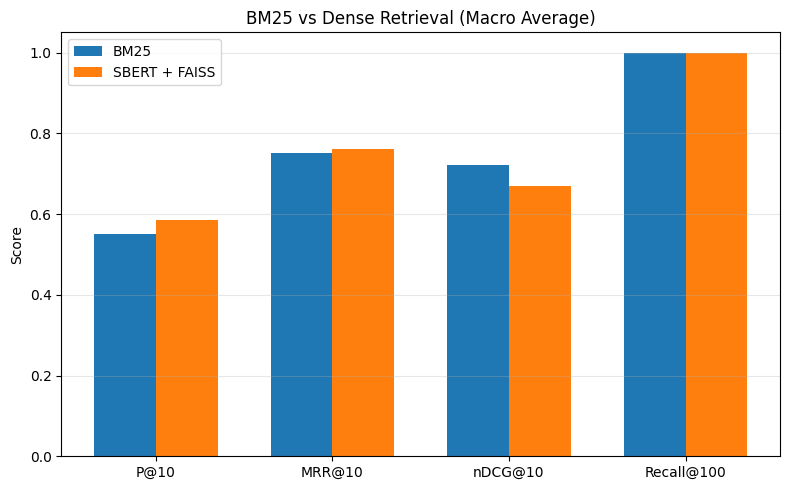

In [49]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ["P@10", "MRR@10", "nDCG@10", "Recall@100"]

bm25_avg = bm25_results[metrics].mean()
dense_avg = dense_results[metrics].mean()

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, bm25_avg, width, label="BM25")
plt.bar(x + width/2, dense_avg, width, label="SBERT + FAISS")

plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("BM25 vs Dense Retrieval (Macro Average)")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


BM25 queries: 8 Dense queries: 7 Aligned: 7


,qid,P@10_BM25,P@10_SBERT
0,Q01,0.0,0.0
1,Q02,0.2,0.2
2,Q03,1.0,1.0
3,Q04,1.0,0.9
4,Q06,0.9,0.8
5,Q07,1.0,1.0
6,Q08,0.3,0.2


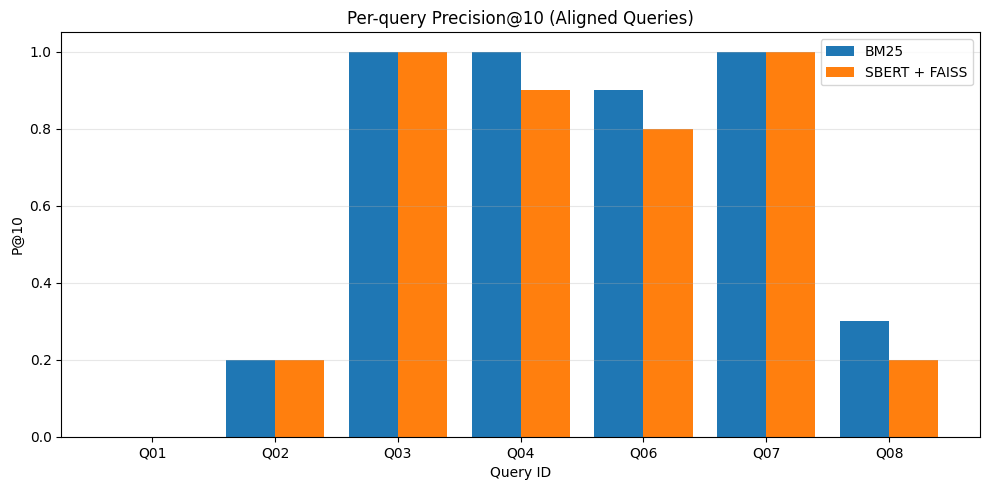

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure qid exists and is string
bm25_results["qid"] = bm25_results["qid"].astype(str)
dense_results["qid"] = dense_results["qid"].astype(str)

# Align on common qids
aligned = bm25_results[["qid", "P@10"]].merge(
    dense_results[["qid", "P@10"]],
    on="qid",
    how="inner",
    suffixes=("_BM25", "_SBERT")
).sort_values("qid")

print("BM25 queries:", len(bm25_results), "Dense queries:", len(dense_results), "Aligned:", len(aligned))
display(aligned)

# Plot
x = np.arange(len(aligned))

plt.figure(figsize=(10,5))
plt.bar(x - 0.2, aligned["P@10_BM25"], 0.4, label="BM25")
plt.bar(x + 0.2, aligned["P@10_SBERT"], 0.4, label="SBERT + FAISS")

plt.xticks(x, aligned["qid"])
plt.xlabel("Query ID")
plt.ylabel("P@10")
plt.title("Per-query Precision@10 (Aligned Queries)")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [51]:
narrow_qids = ["Q01", "Q02", "Q08"]  # fairness, privacy, beneficence
broad_qids  = ["Q03", "Q04", "Q06", "Q07"]

def group_avg(df, qids):
    return df[df["qid"].isin(qids)]["P@10"].mean()

bm25_narrow = group_avg(bm25_results, narrow_qids)
dense_narrow = group_avg(dense_results, narrow_qids)

bm25_broad = group_avg(bm25_results, broad_qids)
dense_broad = group_avg(dense_results, broad_qids)


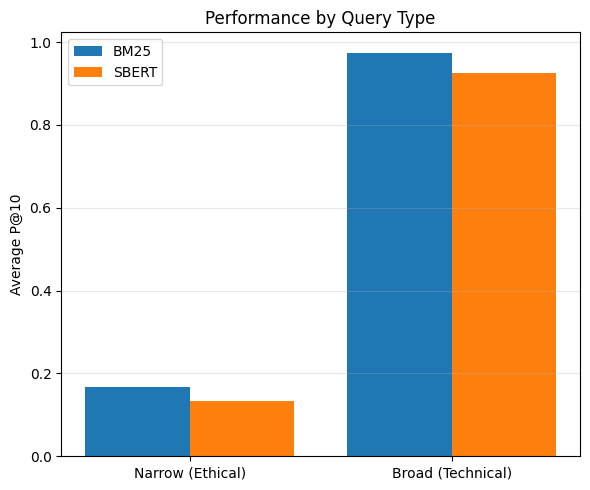

In [52]:
labels = ["Narrow (Ethical)", "Broad (Technical)"]
bm25_vals = [bm25_narrow, bm25_broad]
dense_vals = [dense_narrow, dense_broad]

x = np.arange(len(labels))

plt.figure(figsize=(6,5))
plt.bar(x - 0.2, bm25_vals, 0.4, label="BM25")
plt.bar(x + 0.2, dense_vals, 0.4, label="SBERT")

plt.xticks(x, labels)
plt.ylabel("Average P@10")
plt.title("Performance by Query Type")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()
